In [201]:
# Import required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import seaborn as sns
from scipy import stats

In [202]:
# Read the sales data
df = pd.read_csv("resources/store_data.csv")
# Display sample data
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Unit Price,Price without discount,Unit Cost
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0%,41.9136,130.9800,130.98,20.9568
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0%,219.5820,243.9800,243.98,73.1940
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0%,6.8714,7.3100,7.31,3.4357
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,45%,-383.0310,191.5155,348.21,80.0883
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,20%,2.5164,11.1840,13.98,4.0542


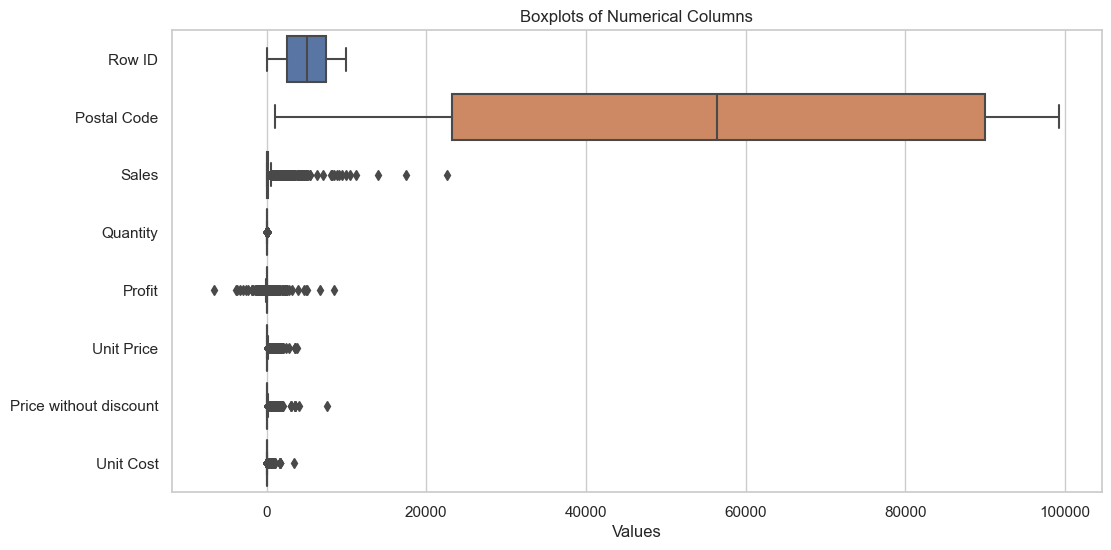

In [203]:
# Assuming 'df' is your DataFrame
numerical_columns = df.select_dtypes(include=['float64', 'int64'])

# Set the style for the plots (optional)
sns.set(style="whitegrid")

# Create boxplots for all numerical columns
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.boxplot(data=numerical_columns, orient="h")  # "orient" specifies horizontal orientation

# Add labels and title
plt.xlabel('Values')
plt.title('Boxplots of Numerical Columns')

# Show the plot
plt.show()

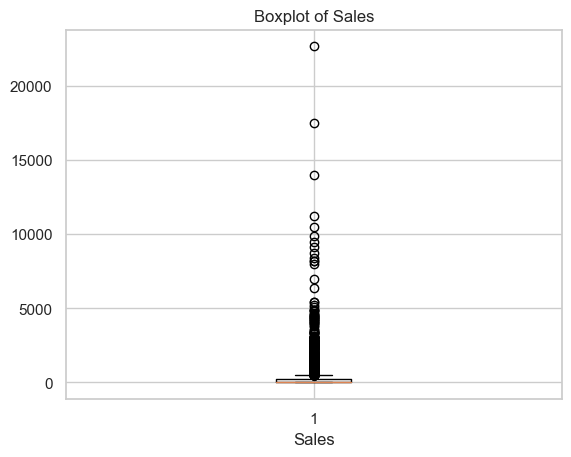

In [204]:
# Assuming 'df' is your DataFrame
data = df['Sales']

# Create a boxplot
plt.boxplot(data)

# Add labels and title
plt.xlabel('Sales')
plt.title('Boxplot of Sales')

# Show the plot
plt.show()

In [205]:
df.drop(index= df[(df['Sales'] > 13000)].index, inplace=True)

In [206]:
# Determine the number of unique values in each column.
df.nunique()

Row ID                    9991
Order ID                  5009
Order Date                1237
Ship Date                 1334
Ship Mode                    4
Customer ID                793
Customer Name              793
Segment                      3
Country                      1
City                       531
State                       49
Postal Code                631
Region                       4
Product ID                1861
Category                     3
Sub-Category                17
Product Name              1849
Sales                     5822
Quantity                    14
Discount                    12
Profit                    7284
Unit Price                2664
Price without discount    1094
Unit Cost                 1561
dtype: int64

In [207]:
#change into datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

df['Order Year'] = df['Order Date'].dt.year

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9991 entries, 0 to 9993
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Row ID                  9991 non-null   int64         
 1   Order ID                9991 non-null   object        
 2   Order Date              9991 non-null   datetime64[ns]
 3   Ship Date               9991 non-null   datetime64[ns]
 4   Ship Mode               9991 non-null   object        
 5   Customer ID             9991 non-null   object        
 6   Customer Name           9991 non-null   object        
 7   Segment                 9991 non-null   object        
 8   Country                 9991 non-null   object        
 9   City                    9991 non-null   object        
 10  State                   9991 non-null   object        
 11  Postal Code             9991 non-null   int64         
 12  Region                  9991 non-null   object  

In [208]:
# Split the monthly sales by date
sales_data = df[['Order Date', 'Sales']].copy()

# Convert 'Order Date' column to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Extract year and month
sales_data['Year'] = sales_data['Order Date'].dt.year
sales_data['Month'] = sales_data['Order Date'].dt.month

# Group by year and month and sum the sales
sales_data = sales_data.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Create the 'Date' column with the last day of the month
sales_data['Date'] = pd.to_datetime(sales_data[['Year', 'Month']].assign(day=1)) + pd.DateOffset(months=1) - pd.DateOffset(days=1)

# Create the 'sales_df' DataFrame
sales_df = sales_data[['Date', 'Sales', 'Month', 'Year']]

# Display the first few rows of the resulting DataFrame
sales_df.head()

,Date,Sales,Month,Year
0,2014-01-31,14236.895,1,2014
1,2014-02-28,4519.892,2,2014
2,2014-03-31,33052.529,3,2014
3,2014-04-30,28295.345,4,2014
4,2014-05-31,23648.287,5,2014


In [209]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    48 non-null     datetime64[ns]
 1   Sales   48 non-null     float64       
 2   Month   48 non-null     int64         
 3   Year    48 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.6 KB


In [210]:
#Preprocess the data
sales_df.sort_values('Date')[:5]



,Date,Sales,Month,Year
0,2014-01-31,14236.895,1,2014
1,2014-02-28,4519.892,2,2014
2,2014-03-31,33052.529,3,2014
3,2014-04-30,28295.345,4,2014
4,2014-05-31,23648.287,5,2014


In [211]:
X = sales_df[['Year', 'Month']]  # Features
y = sales_df['Sales']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [212]:
# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 91493881.83976555
Root Mean Squared Error: 9565.243428149937
R-squared: 0.5847888977310611


In [213]:
coefficients = model.coef_
print("Coefficients:", coefficients)

Coefficients: [7783.1952959  5362.83564702]


R-squared (R2) for Actual Sales in 2014: 1.0
R-squared (R2) for Predicted Sales in 2014: 0.6032216319631418


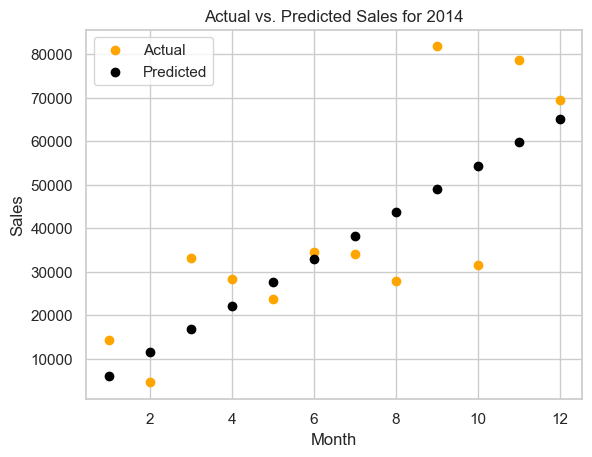

In [214]:
# Features used during model training
features_used_during_training = ['Year', 'Month']

# Filter the data for the year 2014
sales_df_2014 = sales_df[sales_df['Year'] == 2014]

# Extract features (Year and Month) for the year 2014
X_2014 = sales_df_2014[features_used_during_training]

# Predict the sales for 2014 using the model
y_pred_2014 = model.predict(X_2014)

# Actual sales for 2014 (assuming you have this data)
y_2014 = sales_df_2014['Sales']

# Calculate R2 for actual and predicted sales in 2014
r2_actual_2014 = r2_score(y_2014, y_2014)  # R2 for actual sales in 2014
r2_predicted_2014 = r2_score(y_2014, y_pred_2014)  # R2 for predicted sales in 2014

print("R-squared (R2) for Actual Sales in 2014:", r2_actual_2014)
print("R-squared (R2) for Predicted Sales in 2014:", r2_predicted_2014)

# Create a plot that shows actual sales vs. predicted sales for 2014
plt.scatter(X_2014['Month'], y_2014, color='orange', label='Actual')
plt.scatter(X_2014['Month'], y_pred_2014, color='black', label='Predicted')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.title('Actual vs. Predicted Sales for 2014')
plt.show()


R-squared (R2) for Actual Sales in 2015: 1.0
R-squared (R2) for Predicted Sales in 2015: 0.5632306631900493


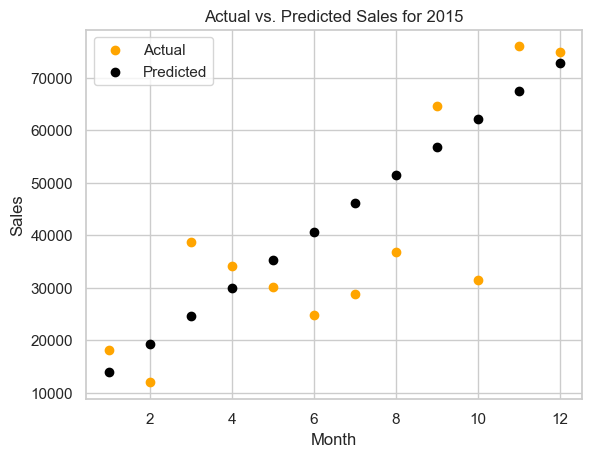

In [215]:
# Features used during model training
features_used_during_training = ['Year', 'Month']

# Filter the data for the year 2015
sales_df_2015 = sales_df[sales_df['Year'] == 2015]

# Extract features (Year and Month) for the year 2015
X_2015 = sales_df_2015[features_used_during_training]

# Predict the sales for 2015 using the model
y_pred_2015 = model.predict(X_2015)

# Actual sales for 2015 (assuming you have this data)
y_2015 = sales_df_2015['Sales']

# Calculate R2 for actual and predicted sales in 2015
r2_actual_2015 = r2_score(y_2015, y_2015)  # R2 for actual sales in 2015
r2_predicted_2015 = r2_score(y_2015, y_pred_2015)  # R2 for predicted sales in 2015

print("R-squared (R2) for Actual Sales in 2015:", r2_actual_2015)
print("R-squared (R2) for Predicted Sales in 2015:", r2_predicted_2015)

# Create a plot that shows actual sales vs. predicted sales for 2015
plt.scatter(X_2015['Month'], y_2015, color='orange', label='Actual')
plt.scatter(X_2015['Month'], y_pred_2015, color='black', label='Predicted')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.title('Actual vs. Predicted Sales for 2015')
plt.show()


R-squared (R2) for Actual Sales in 2016: 1.0
R-squared (R2) for Predicted Sales in 2016: 0.5451755798603757


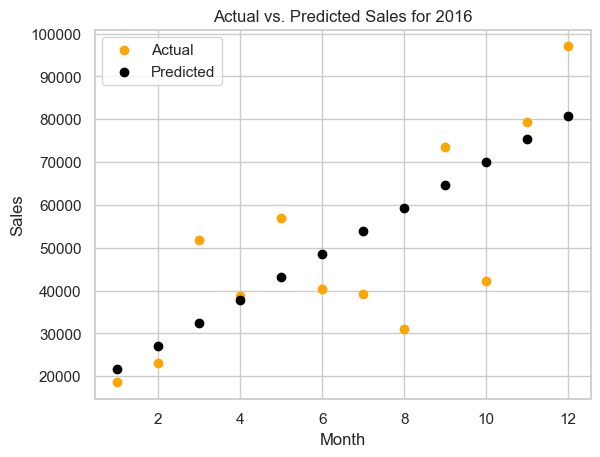

In [216]:
# Features used during model training
features_used_during_training = ['Year', 'Month']

# Filter the data for the year 2016
sales_df_2016 = sales_df[sales_df['Year'] == 2016]

# Extract features (Year and Month) for the year 2016
X_2016 = sales_df_2016[features_used_during_training]

# Predict the sales for 2016 using the model
y_pred_2016 = model.predict(X_2016)

# Actual sales for 2016 (assuming you have this data)
y_2016 = sales_df_2016['Sales']

# Calculate R2 for actual and predicted sales in 2016
r2_actual_2016 = r2_score(y_2016, y_2016)  # R2 for actual sales in 2016
r2_predicted_2016 = r2_score(y_2016, y_pred_2016)  # R2 for predicted sales in 2016

print("R-squared (R2) for Actual Sales in 2016:", r2_actual_2016)
print("R-squared (R2) for Predicted Sales in 2016:", r2_predicted_2016)

# Create a plot that shows actual sales vs. predicted sales for 2016
plt.scatter(X_2016['Month'], y_2016, color='orange', label='Actual')
plt.scatter(X_2016['Month'], y_pred_2016, color='black', label='Predicted')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.title('Actual vs. Predicted Sales for 2016')
plt.show()


R-squared (R2) for Actual Sales in 2017: 1.0
R-squared (R2) for Predicted Sales in 2017: 0.7107999081704665


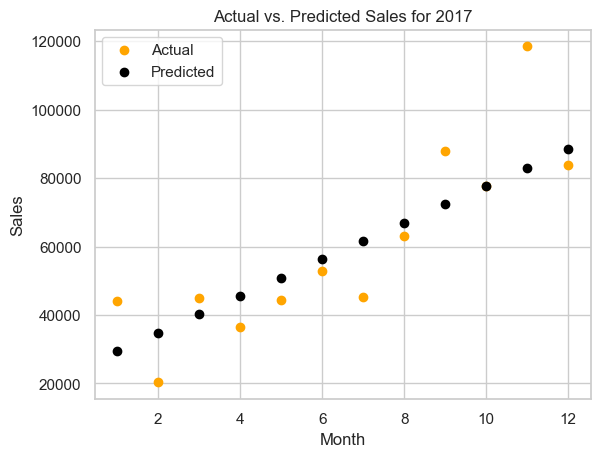

In [217]:
# Features used during model training
features_used_during_training = ['Year', 'Month']

# Filter the data for the year 2017
sales_df_2017 = sales_df[sales_df['Year'] == 2017]

# Extract features (Year and Month) for the year 2017
X_2017 = sales_df_2017[features_used_during_training]

# Predict the sales for 2017 using the model
y_pred_2017 = model.predict(X_2017)

# Actual sales for 2017 (assuming you have this data)
y_2017 = sales_df_2017['Sales']

# Calculate R2 for actual and predicted sales in 2017
r2_actual_2017 = r2_score(y_2017, y_2017)  # R2 for actual sales in 2017
r2_predicted_2017 = r2_score(y_2017, y_pred_2017)  # R2 for predicted sales in 2017

print("R-squared (R2) for Actual Sales in 2017:", r2_actual_2017)
print("R-squared (R2) for Predicted Sales in 2017:", r2_predicted_2017)

# Create a plot that shows actual sales vs. predicted sales for 2017
plt.scatter(X_2017['Month'], y_2017, color='orange', label='Actual')
plt.scatter(X_2017['Month'], y_pred_2017, color='black', label='Predicted')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.title('Actual vs. Predicted Sales for 2017')
plt.show()



In [218]:
# Example: Predict sales for January 2024
new_data = pd.DataFrame({'Year': [2024], 'Month': [1]})
predicted_sales = model.predict(new_data)
print("Predicted Sales for January 2024:", predicted_sales[0])

Predicted Sales for January 2024: 83934.47127916664
